## MLP: DINO -> Kinematics
- DINO features and kinematics are always centerd within the day (the day's mean is subtracted).
- train, val and test data are split by days (whole days are assigned into one of those sets)
- if ANY joint has a NaN value, the whole frame is removed from the dataset
- it is not taking into account the temporal information of the frames (i.e. the order of the frames is not considered). It just predicts the kinematics from the current frame
- It prints how many frames is in each subdataset (train/val/test)
- computes the MSE bound - it is the MSE of the mean of the train set, meaning that if the model predicts the mean of the train set, this is the error that we would get


In [12]:
model_save_path = 'MLP_DINO_to_kinematics.pth'

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

# Custom Dataset class
class DinoKinematicsDataset(Dataset):
    """
    A custom Dataset class for Dino Kinematics data.
    DINO features and kinematics are always centerd within the day (the day's mean is subtracted) (in load_data())

    Args:
        dino_features (list of np.ndarray): List of numpy arrays containing dino features for each file.
        kinematics (list of np.ndarray): List of numpy arrays containing kinematics data for each file.
        in_dataset (list of np.ndarray): List of numpy arrays indicating whether each frame should be included.
        print_end_of_files (bool): If True, prints the length of data after processing each file.

    Attributes:
        data (torch.tensor): Tensor containing the dino features.
        targets (torch.tensor): Tensor containing the kinematics data.
    
    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns the dino features and kinematics data for the given index.
    """
    def __init__(self, dino_features, kinematics, in_dataset, print_end_of_files=False):
        self.data = []
        self.targets = []

        # Preprocess the data
        for d_feats, kin, in_ds in zip(dino_features, kinematics, in_dataset):
            print("#", end="")
            for df, k, i in zip(d_feats, kin, in_ds):
                # for simplicity, skip the sample if any of the values is nan
                if np.isnan(k[[0, 13, 14, 15, 16], :2]).any():
                    continue
                if i == 1:
                    self.data.append(df)
                    self.targets.append(k[[0, 13, 14, 15, 16], :2].flatten())
            
            if print_end_of_files:
                print(len(self.data))

        print(len(self.data))

        self.data = torch.tensor(self.data, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

def load_data(dino_dir, kinematics_dir, seed=42):
    """
    Loads and preprocesses dino features, kinematics data, and in_dataset indicators from the specified directories.
    DINO features and kinematics are always centerd within the day (the day's mean is subtracted).

    Args:
        dino_dir (str): Directory containing dino features files.
        kinematics_dir (str): Directory containing kinematics and in_dataset files.
        seed (int): Random seed for shuffling the data.

    Returns:
        tuple: (dino_features, kinematics, in_dataset, filenames)
            dino_features (list of np.ndarray): List of numpy arrays with dino features.
            kinematics (list of np.ndarray): List of numpy arrays with kinematics data.
            in_dataset (list of np.ndarray): List of numpy arrays indicating whether each frame should be included.
            filenames (list of str): List of base filenames without extensions.
    """
    dino_files = [f for f in os.listdir(dino_dir) if f.endswith('_features.npy')]

    # shuffle the dino_files with a seed
    np.random.seed(seed)
    np.random.shuffle(dino_files)

    # if there is a file containing cam0_002422061428_record_14_09_2023_1541_03, make sure, it's at the end of the array:
    # dino_files = sorted(dino_files, key=lambda x: 'cam0_002422061428_record_14_09_2023_1541_03_features.npy' in x)

    dino_features = []
    kinematics = []
    in_dataset = []
    filenames = []

    for d_file in dino_files:
        base_name = d_file.replace('_features.npy', '')
        filenames.append(base_name)
        k_file = f'{base_name}_kinematics.npy'
        i_file = f'{base_name}_in_dataset.npy'
        
        k_path = os.path.join(kinematics_dir, k_file)
        i_path = os.path.join(kinematics_dir, i_file)
        
        if os.path.exists(k_path) and os.path.exists(i_path):
            dino_feat = np.load(os.path.join(dino_dir, d_file))
            kinematic = np.load(k_path)
            in_ds = np.load(i_path)

            # Subtract mean
            dino_feat -= np.nanmean(dino_feat, axis=0) # CAREFUL WITH THE NANS!!!
            kinematic -= np.nanmean(kinematic, axis=0)

            dino_features.append(dino_feat)
            kinematics.append(kinematic)
            in_dataset.append(in_ds)
    
    return dino_features, kinematics, in_dataset, filenames

def mse_bound(dino_features, kinematics, in_dataset):
    all_data = []
    all_targets = []

    for d_feats, kin, in_ds in zip(dino_features, kinematics, in_dataset):
        for df, k, i in zip(d_feats, kin, in_ds):
            if i == 1:
                all_data.append(df)
                all_targets.append(k)

    all_data = np.array(all_data)
    all_targets = np.array(all_targets)

    # Calculate the average prediction and MSE
    average_prediction = np.mean(all_targets, axis=0)
    mse = np.mean((all_targets - average_prediction) ** 2)

    print(f'Mean Squared Error for average prediction: {mse}')

# Load data
dino_features, kinematics, in_dataset, filenames = load_data('/media/cyberspace007/T7/martin/experiments/dino_features_for_kinematics_prediction', '/media/cyberspace007/T7/martin/data/kinematics', seed=42)

# Split files into train, validation, and test sets
num_files = len(dino_features)
train_files = int(0.8 * num_files)
val_files = int(0.1 * num_files)
test_files = num_files - train_files - val_files

train_dino = dino_features[:train_files]
train_kinematics = kinematics[:train_files]
train_in_dataset = in_dataset[:train_files]
train_filenames = filenames[:train_files]

val_dino = dino_features[train_files:train_files + val_files]
val_kinematics = kinematics[train_files:train_files + val_files]
val_in_dataset = in_dataset[train_files:train_files + val_files]
val_filenames = filenames[train_files:train_files + val_files]

test_dino = dino_features[train_files + val_files:]
test_kinematics = kinematics[train_files + val_files:]
test_in_dataset = in_dataset[train_files + val_files:]
test_filenames = filenames[train_files + val_files:]
print(test_filenames)

# Prepare datasets
print("Train dataset:")
train_dataset = DinoKinematicsDataset(train_dino, train_kinematics, train_in_dataset)
print("Val dataset:")
val_dataset = DinoKinematicsDataset(val_dino, val_kinematics, val_in_dataset)
print("Test dataset:")
test_dataset = DinoKinematicsDataset(test_dino, test_kinematics, test_in_dataset, print_end_of_files=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



/tmp/ipykernel_901954/2721351898.py:105: RuntimeWarning: Mean of empty slice
  kinematic -= np.nanmean(kinematic, axis=0)


['cam0_911222060374_record_20_09_2023_1334_00', 'cam0_911222060374_record_28_09_2023_1436_30', 'cam0_911222060374_record_08_02_2024_1412_22']
Train dataset:
####################82370
Val dataset:
##5259
Test dataset:
#3358
#3358
#25331
25331


In [6]:
def mse_bound(dino_features, kinematics, in_dataset):
    all_data = []
    all_targets = []

    for d_feats, kin, in_ds in zip(dino_features, kinematics, in_dataset):
        for df, k, i in zip(d_feats, kin, in_ds):
            if i == 1:
                all_data.append(df)
                all_targets.append(k)

    all_data = np.array(all_data)
    all_targets = np.array(all_targets)

    # Calculate the average prediction and MSE
    average_prediction = np.mean(all_targets, axis=0)
    mse = np.mean((all_targets - average_prediction) ** 2)

    print(f'Mean Squared Error for average prediction: {mse}')

mse_bound(val_dino, val_kinematics, val_in_dataset)
mse_bound(test_dino, test_kinematics, test_in_dataset)

Mean Squared Error for average prediction: 372.00973614991784


Mean Squared Error for average prediction: 317.275350193994


In [15]:
# Define the MLP model with additional layers and regularization
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_units=128):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 512)
        self.hidden2 = nn.Linear(512, 128)
        self.output = nn.Linear(128, output_size)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(128)
    
    def forward(self, x):
        x = torch.relu(self.batch_norm1(self.hidden1(x)))
        x = self.dropout(x)
        x = torch.relu(self.batch_norm2(self.hidden2(x)))
        # save the output of this layer as features to be returned
        features = x
        x = self.output(x)
        return x, features

# Initialize the model, loss function, and optimizer
input_size = train_dataset[0][0].shape[0]
output_size = train_dataset[0][1].shape[0]
model = MLP(input_size, output_size).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
print(model)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        outputs, _ = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.cuda(), target.cuda()
            # check if in data or target is a nan value. If so, pritnt "OMG"
            if torch.isnan(data).any() or torch.isnan(target).any():
                print("OMG")
            outputs, _ = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}')

# Testing
model.eval()
test_loss = 0.0
test_gold = []
test_predictions = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        outputs, _ = model(data)
        test_predictions.append(outputs.cpu().numpy())
        test_gold.append(target.cpu().numpy())
        loss = criterion(outputs, target)
        test_loss += loss.item()

print(f'Test Loss: {test_loss / len(test_loader)}')



MLP(
  (hidden1): Linear(in_features=2048, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 1, Loss: 14.587407461234502, Validation Loss: 13.909741028245673
Epoch 2, Loss: 7.817332905086672, Validation Loss: 15.242419538727725
Epoch 3, Loss: 6.932888825857861, Validation Loss: 15.447077064629061
Epoch 4, Loss: 6.321137282048693, Validation Loss: 13.480620582419705
Epoch 5, Loss: 5.835209997544378, Validation Loss: 15.552570503878306
Epoch 6, Loss: 5.525680151600275, Validation Loss: 15.222950039139713
Epoch 7, Loss: 5.429673367035315, Validation Loss: 15.189591347453106
Epoch 8, Loss: 5.162459647248251, Validation Loss: 14.071743973766

In [16]:
# save the model

# Save the model
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Load the model (just to show how to load it)
model = None
# input size is 2024, output size is 10
model = MLP(input_size, output_size).cuda()  # Make sure the model architecture matches
model.load_state_dict(torch.load(model_save_path))
model.eval()
print('Model loaded successfully')

Model saved to MLP_DINO_to_kinematics.pth
Model loaded successfully


Test Loss: 33.81572833085301
x coords


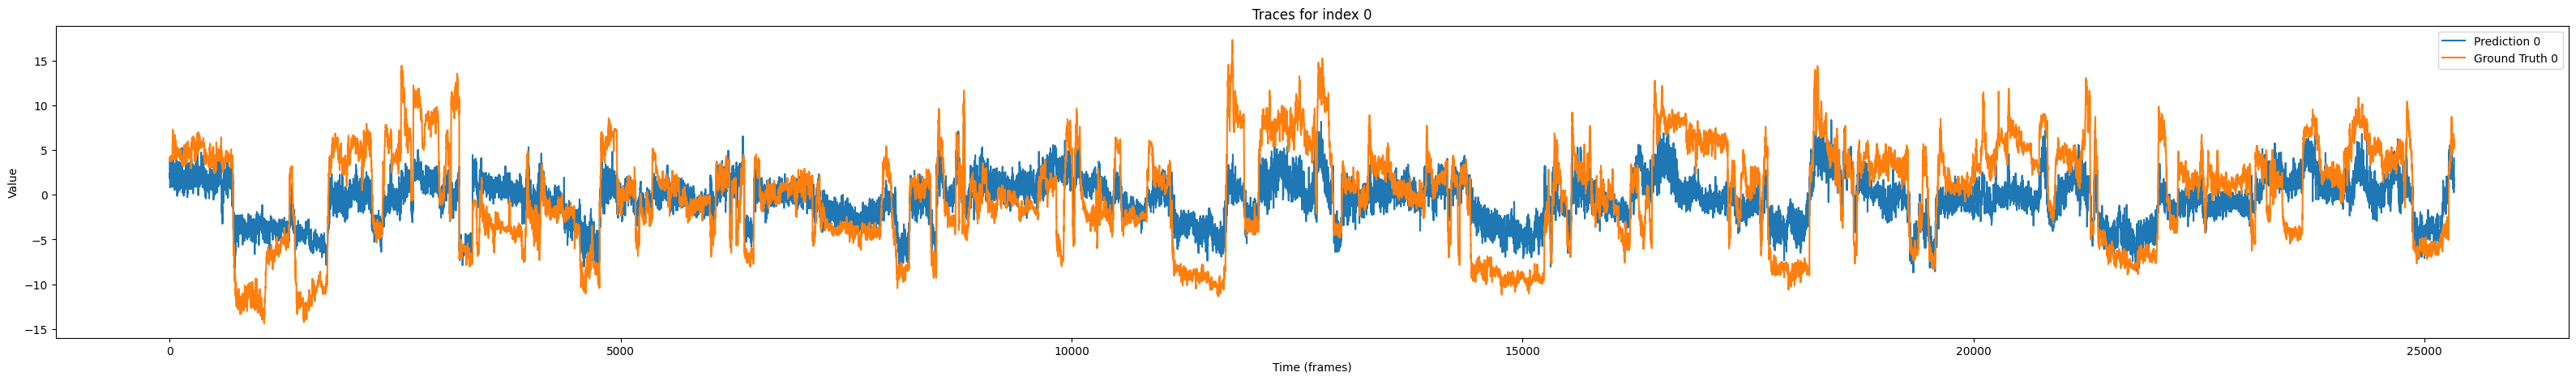

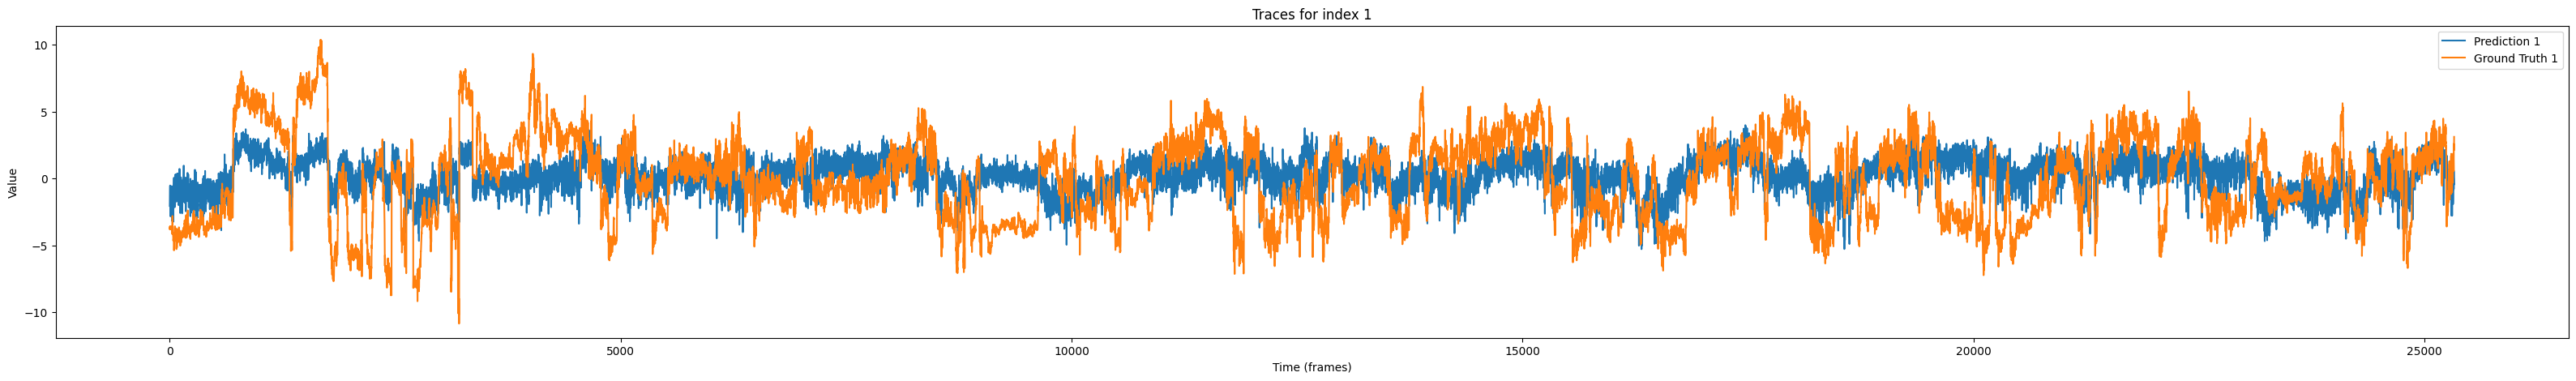

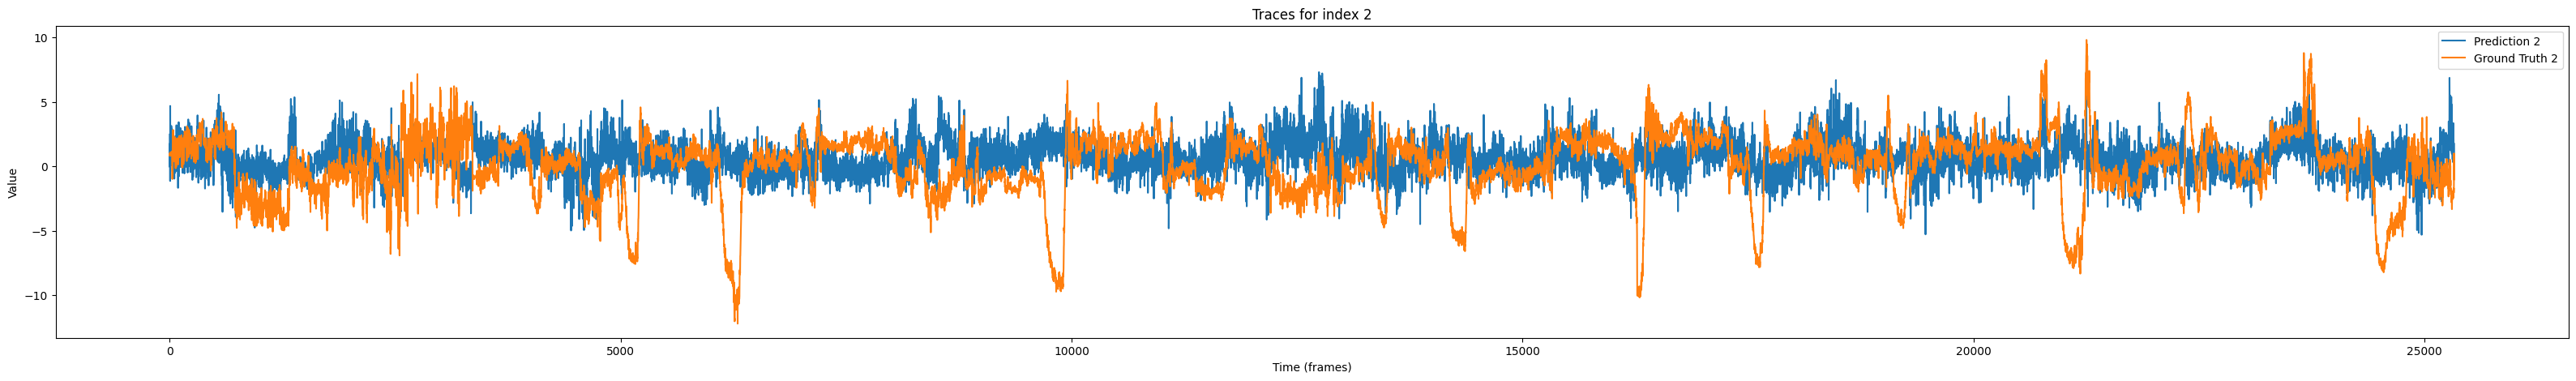

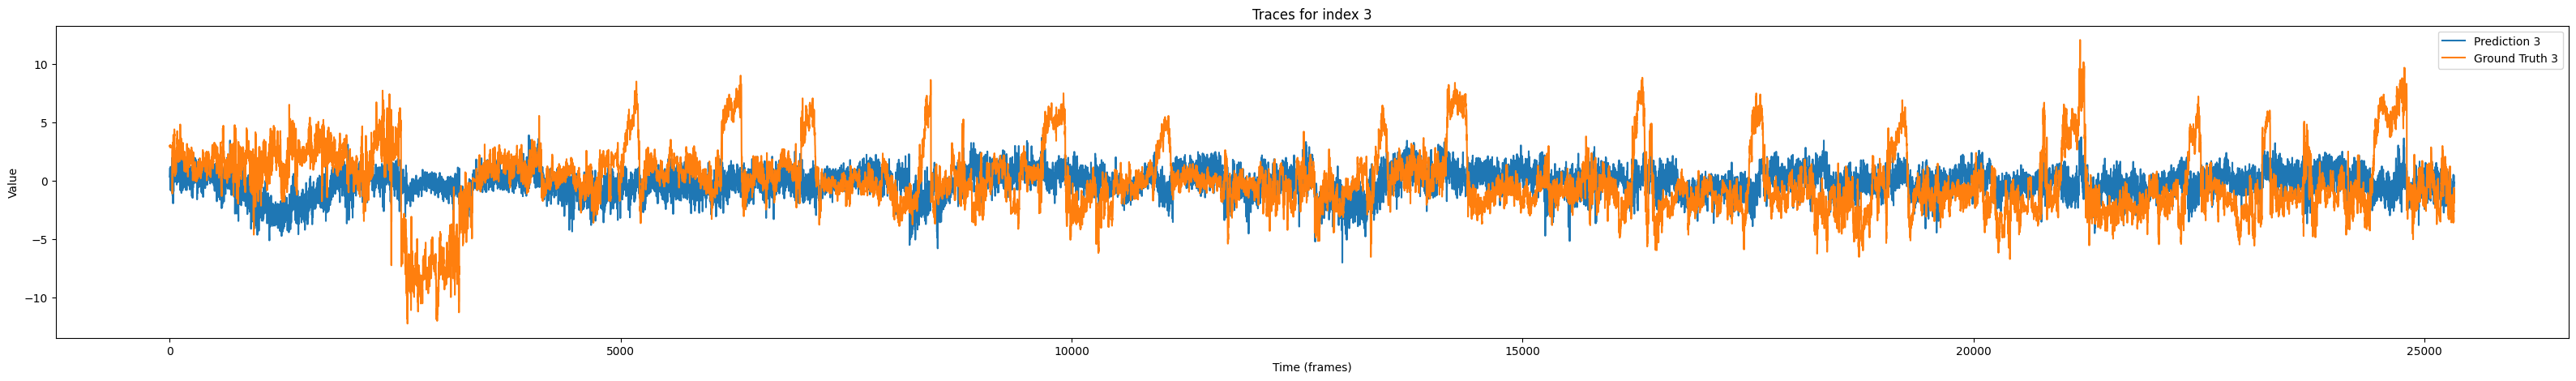

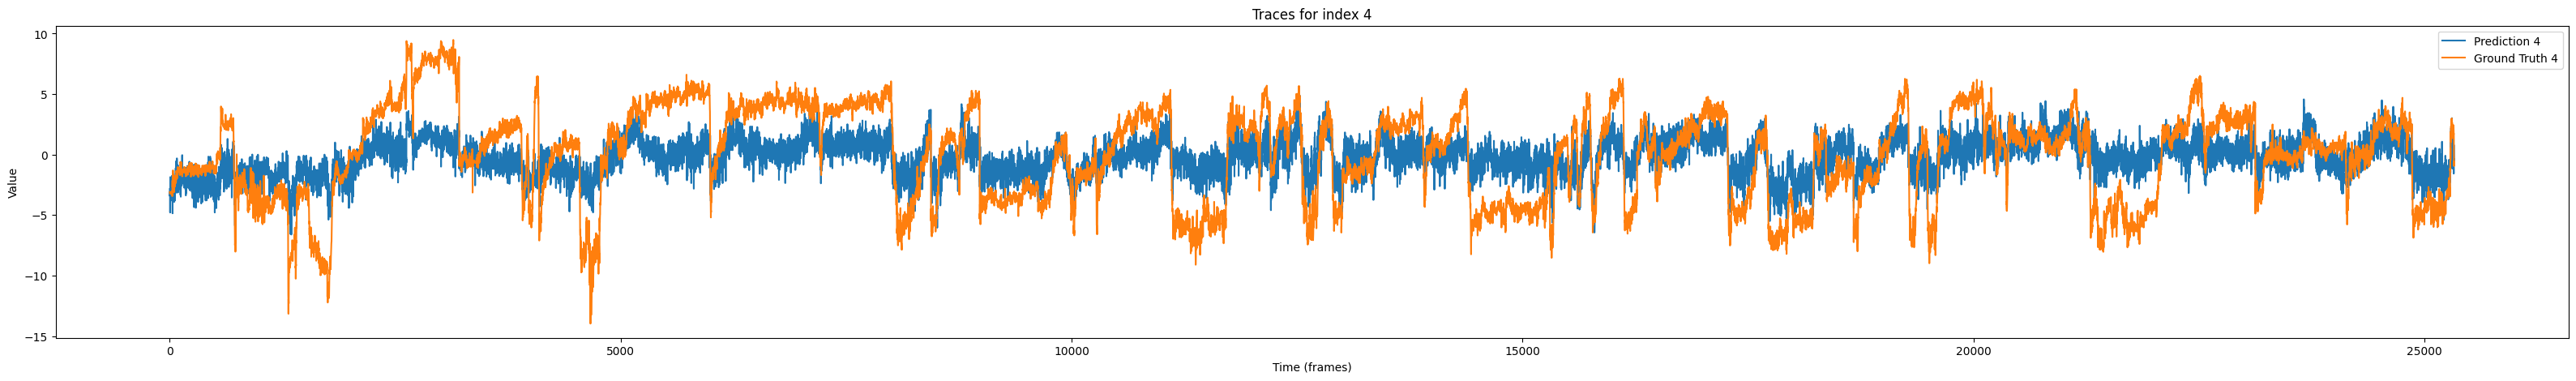

y coords


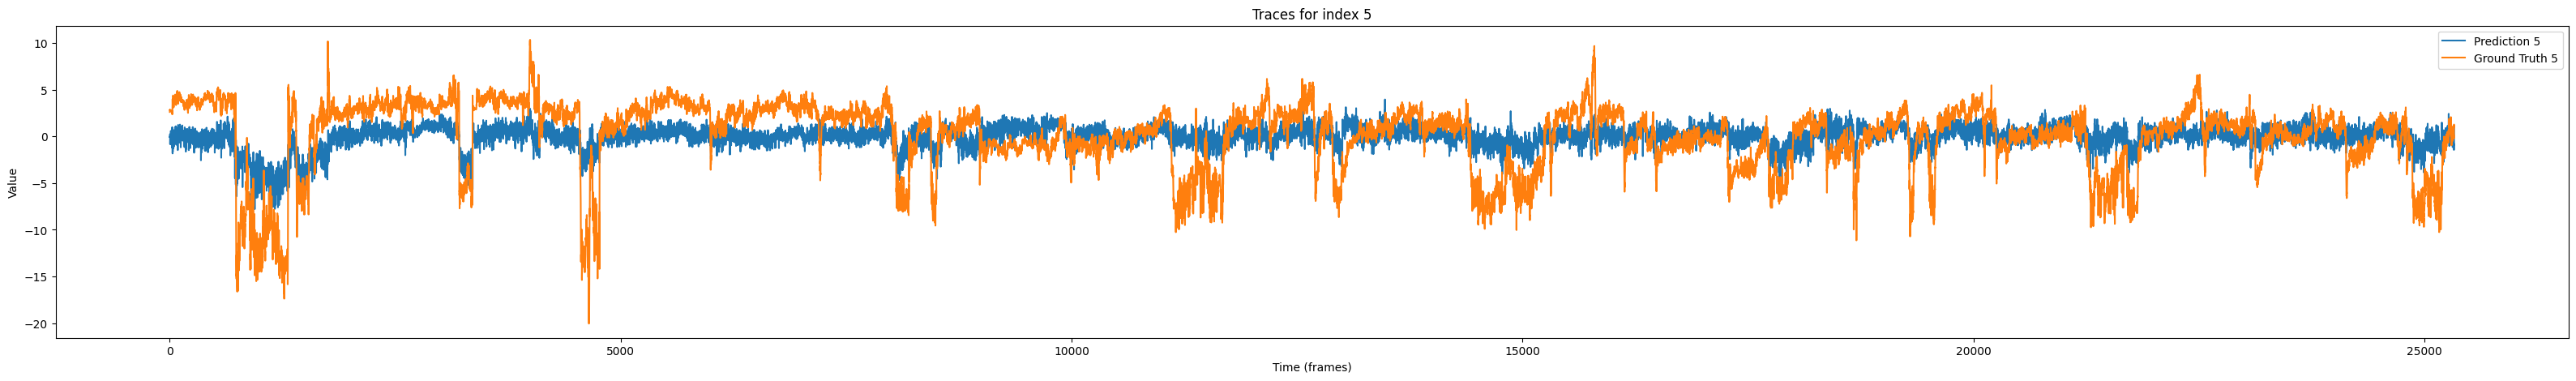

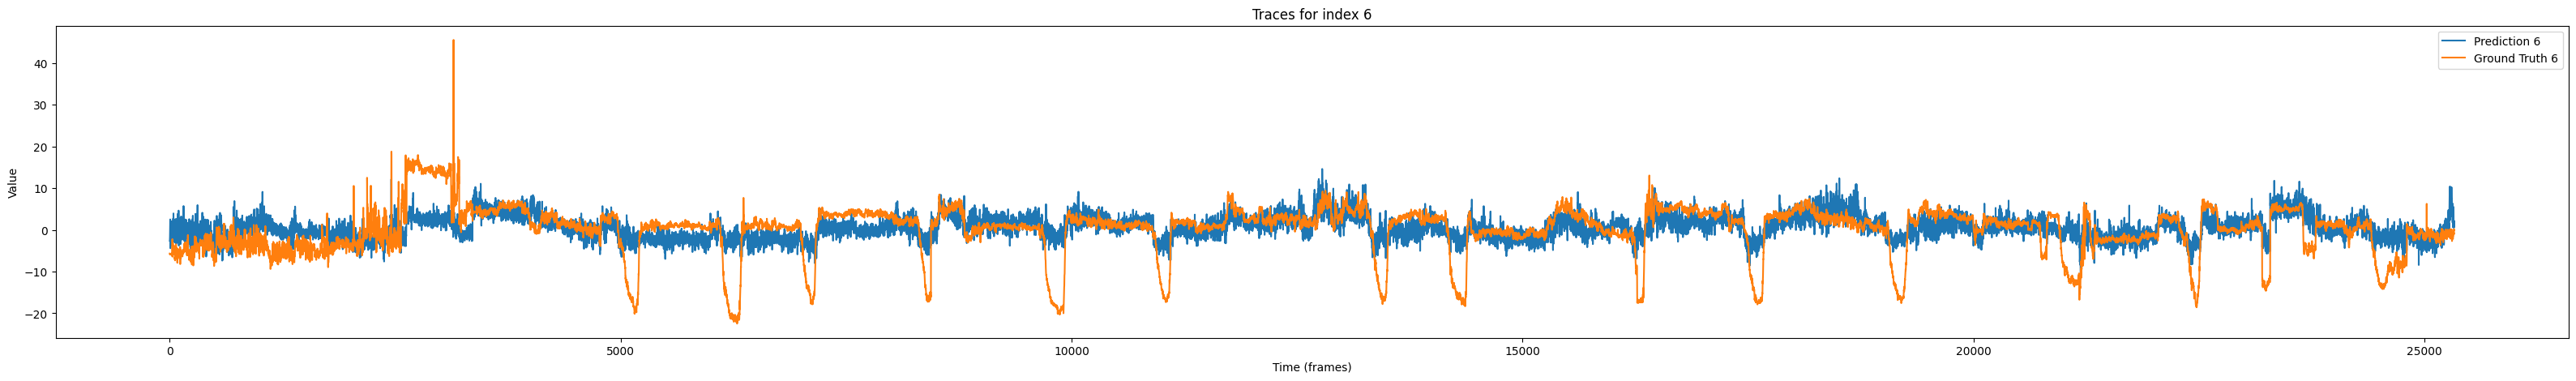

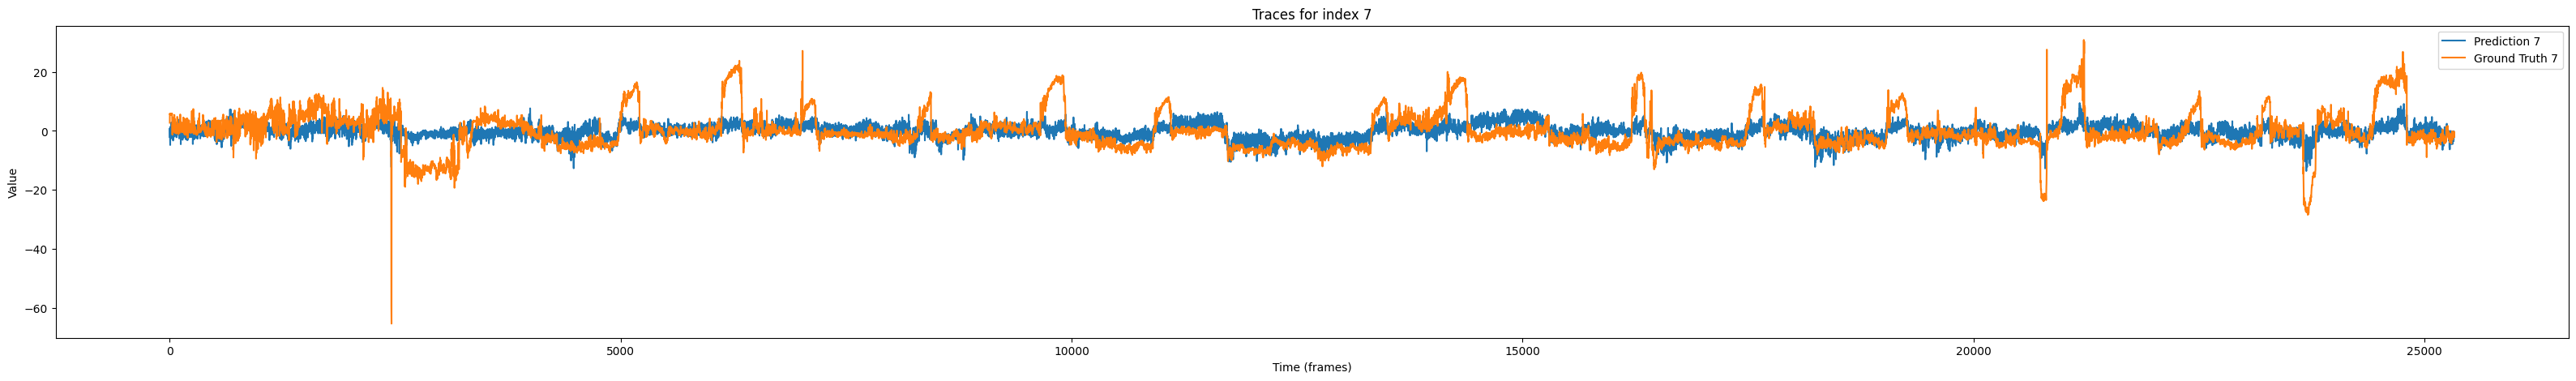

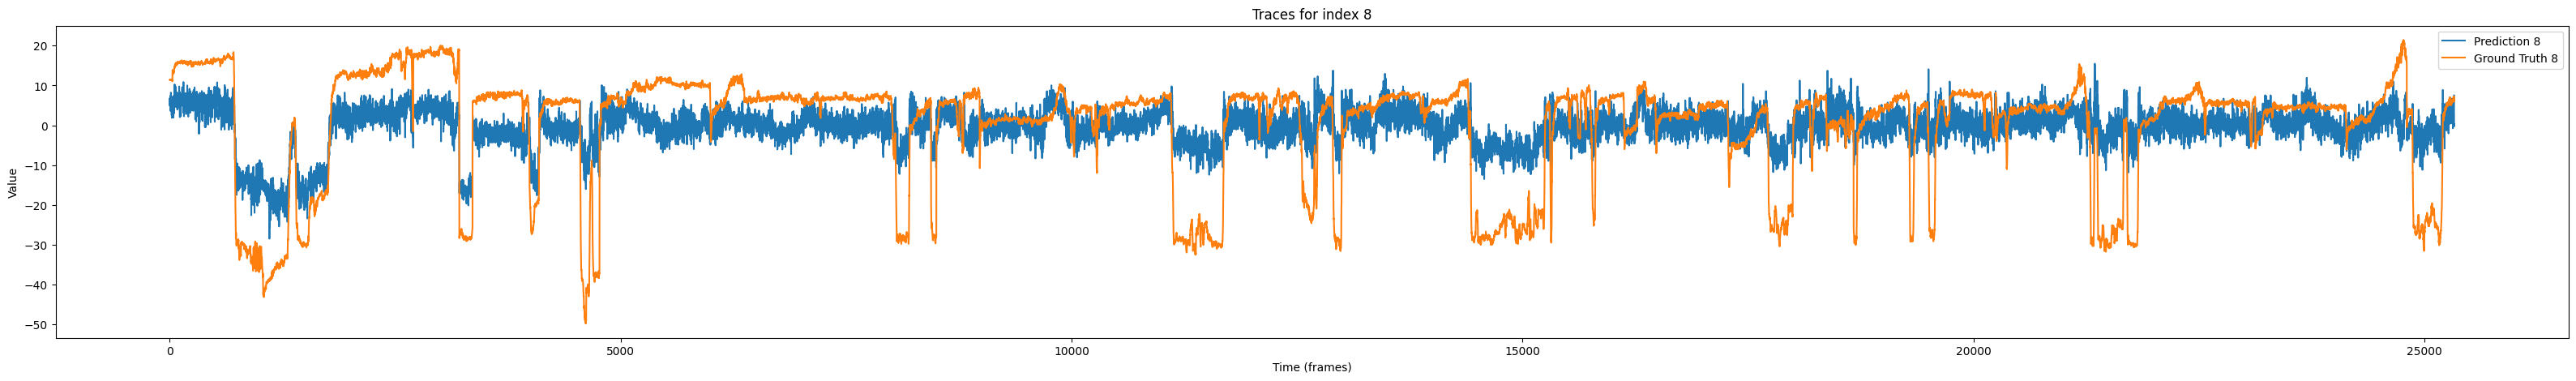

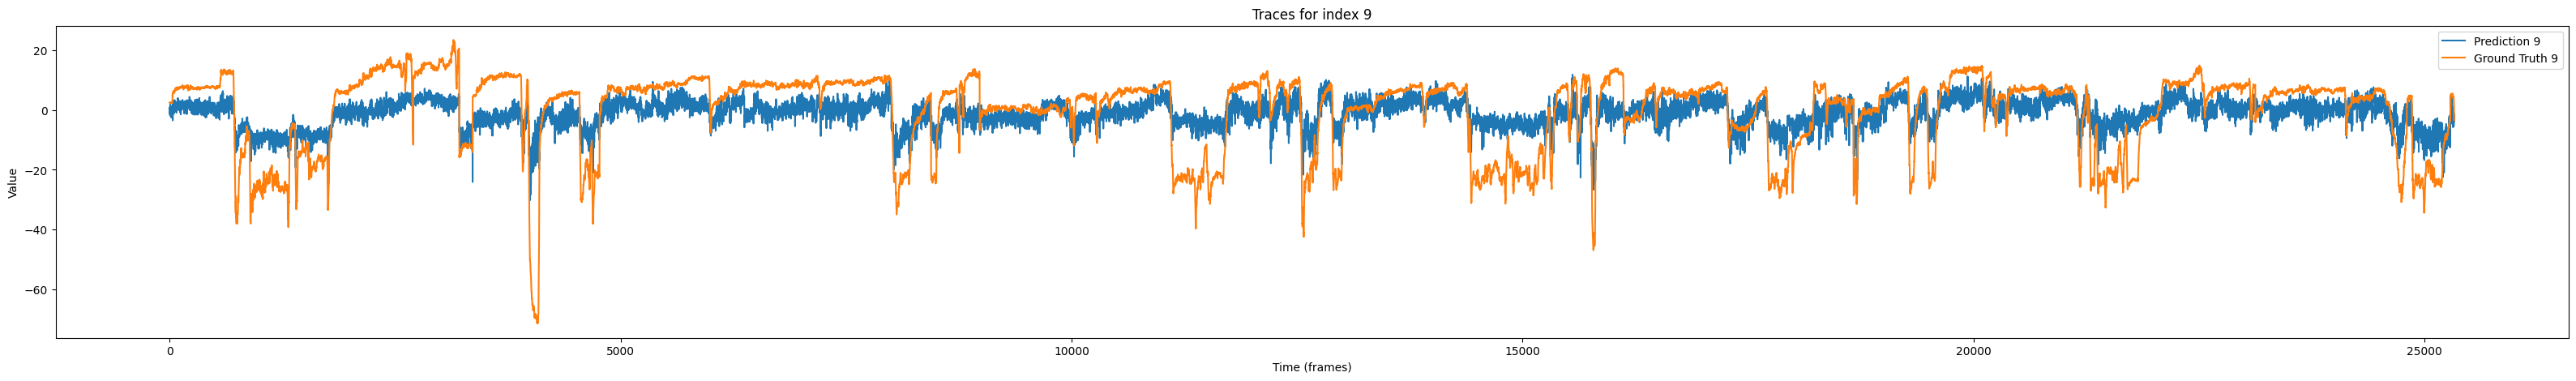

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')

model.eval()
test_loss = 0.0
test_gold = []
test_predictions = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        outputs, feat = model(data)
        test_predictions.append(outputs.cpu().numpy())
        test_gold.append(target.cpu().numpy())
        loss = criterion(outputs, target)
        test_loss += loss.item()

print(f'Test Loss: {test_loss / len(test_loader)}')

# Assuming test_predictions and test_gold are lists of numpy arrays
test_predictions = np.concatenate(test_predictions, axis=0)
test_gold = np.concatenate(test_gold, axis=0)

# Function to plot traces
def plot_traces(predictions, gold, indices):
    for idx in indices:
        plt.figure(figsize=(40, 5))
        plt.plot(predictions[:, idx], label=f'Prediction {idx}')
        plt.plot(gold[:, idx], label=f'Ground Truth {idx}')
        plt.xlabel('Time (frames)')
        plt.ylabel('Value')
        plt.title(f'Traces for index {idx}')
        plt.legend()
        plt.show()

# Example usage
indices = [0, 1, 2, 3, 4]  # replace with your desired indices
print("x coords")
plot_traces(test_predictions, test_gold, indices)
indices = [5, 6, 7, 8, 9]  # replace with your desired indices
print("y coords")
plot_traces(test_predictions, test_gold, indices)


In [27]:
import os
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

# Load the trained model
input_size = 2048
output_size = 10  # Update this to your actual output size
model = MLP(input_size, output_size).cuda()
model.load_state_dict(torch.load(model_save_path))
model.eval()

DINO_folder = '/media/cyberspace007/T7/tmp/dino'  # Set this to your DINO features folder
output_folder = '/media/cyberspace007/T7/tmp/between_dino_and_kinematics'  # Set this to your desired output folder

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each DINO features file
for dino_file in tqdm(os.listdir(DINO_folder)):
    if dino_file.endswith('_features.npy'):
        dino_path = os.path.join(DINO_folder, dino_file)
        
        # Load data in chunks to avoid memory issues
        dino_features = np.load(dino_path, mmap_mode='r')
        K = dino_features.shape[0]
        batch_size = 64  # Adjust batch size according to your memory limits
        
        new_features = []
        
        for start in range(0, K, batch_size):
            end = min(start + batch_size, K)
            dino_batch = dino_features[start:end]
            
            # Convert to torch tensor
            dino_batch_tensor = torch.tensor(dino_batch, dtype=torch.float32).cuda()
            
            # Extract new features
            with torch.no_grad():
                _, batch_features = model(dino_batch_tensor)
                new_features.append(batch_features.cpu().numpy())
        
        # Concatenate all features and save them
        new_features = np.concatenate(new_features, axis=0)
        output_filename = dino_file.replace('_features.npy', '_dino_close_to_kinematics.npy')
        output_path = os.path.join(output_folder, output_filename)

        np.save(output_path, new_features)

        print(f'Saved new features to {output_path}')


 80%|████████  | 8/10 [00:00<00:00, 34.77it/s]

Saved new features to /media/cyberspace007/T7/tmp/between_dino_and_kinematics/cam0_916512060805_record_29_09_2023_1431_39_dino_close_to_kinematics.npy
Saved new features to /media/cyberspace007/T7/tmp/between_dino_and_kinematics/cam0_916512060805_record_15_02_2024_1347_25_dino_close_to_kinematics.npy
Saved new features to /media/cyberspace007/T7/tmp/between_dino_and_kinematics/cam0_916512060805_record_23_01_2024_1512_42_dino_close_to_kinematics.npy
Saved new features to /media/cyberspace007/T7/tmp/between_dino_and_kinematics/cam0_911222060374_record_05_02_2024_1512_03_dino_close_to_kinematics.npy
Saved new features to /media/cyberspace007/T7/tmp/between_dino_and_kinematics/cam0_916512060805_record_21_02_2024_1323_02_dino_close_to_kinematics.npy
Saved new features to /media/cyberspace007/T7/tmp/between_dino_and_kinematics/cam0_916512060805_record_29_02_2024_1420_28_dino_close_to_kinematics.npy
Saved new features to /media/cyberspace007/T7/tmp/between_dino_and_kinematics/cam0_91651206080

100%|██████████| 10/10 [00:00<00:00, 32.38it/s]


Saved new features to /media/cyberspace007/T7/tmp/between_dino_and_kinematics/cam0_911222060374_record_13_02_2024_1511_47_dino_close_to_kinematics.npy
Saved new features to /media/cyberspace007/T7/tmp/between_dino_and_kinematics/cam0_916512060805_record_30_01_2024_1447_52_dino_close_to_kinematics.npy
